# **Global wheat detection - EffiecntDet D5**
***Ido Zada .Id: 203531058***

***Roman Prasolov .Id: 313091746***



Following the previous notebook we decided to try a new model called efficientdet d5.

# **EfficientDet model**



Model efficiency has become increasingly important in
computer vision. In this paper, we systematically study neural network architecture design choices for object detection and propose several key optimizations to improve efficiency. First, it propose a weighted bi-directional feature pyramid network (BiFPN), which allows easy and fast
multi-scale feature fusion; Second, it propose a compound
scaling method that uniformly scales the resolution, depth,
and width for all backbone, feature network, and box/class
prediction networks at the same time. Based on these optimizations and EfficientNet backbones, has been developed
a new family of object detectors, called EfficientDet, which
consistently achieve much better efficiency than prior art
across a wide spectrum of resource constraints

# **Architecture**

The architecture of EfficientDet is shown below and uses the EfficientNet as a backbone network.

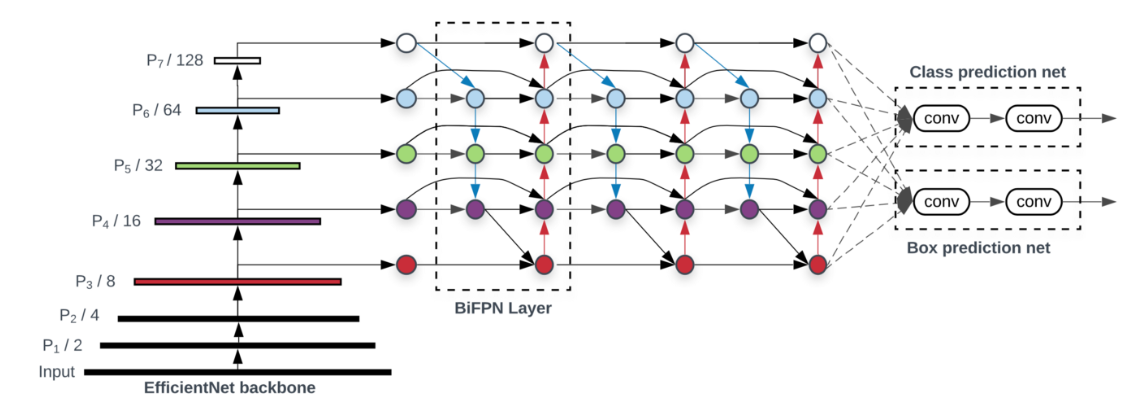

The BiFPN in this network serves as a feature network. It takes the features from the levels 3 - 7 from the backbone network and repeatedly applies the BiFPN.

A BiFPN, or Weighted Bi-directional Feature Pyramid Network, is a type of feature pyramid network which allows easy and fast multi-scale feature fusion. It incorporates the multi-level feature fusion idea from FPN, PANet and NAS-FPN that enables information to flow in both the top-down and bottom-up directions, while using regular and efficient connections. It also utilizes a fast normalized fusion technique. Traditional approaches usually treat all features input to the FPN equally, even those with different resolutions. However, input features at different resolutions often have unequal contributions to the output features. Thus, the BiFPN adds an additional weight for each input feature allowing the network to learn the importance of each. All regular convolutions are also replaced with less expensive depthwise separable convolutions.

**Weighted Feature Fusion**

As mentioned earlier, the fusion of features at different resolutions typically involves resizing them followed by a sum operation. The drawback of this method is that all features are treated equally. Since these features are at different resolutions they usually contribute to the output feature unequally. To get around this an additional weight for each input feature is calculated to allow the network to learn the importance of each feature. A total of three weighted fusion approaches were tested:




1.   **Unbounded Fusion:** This contains an unbounded learnable weight. However, since it is unbounded it can cause training instability, so was discarded
2.   **Softmax-based fusion**: Apply a softmax to each weight thus limiting the weight between 0 and 1, but this lead to a significant increase in latency.

1.   **Fast normalised fusion:** The equation is shown below. Each weight (ωᵢ) is ensured to be greater than or equal to zero via the application of a Relu. The ϵ is set to 0.001 to avoid numerical stability. This calculation was shown to be 30% faster on GPUs compared to the softmax-based method.


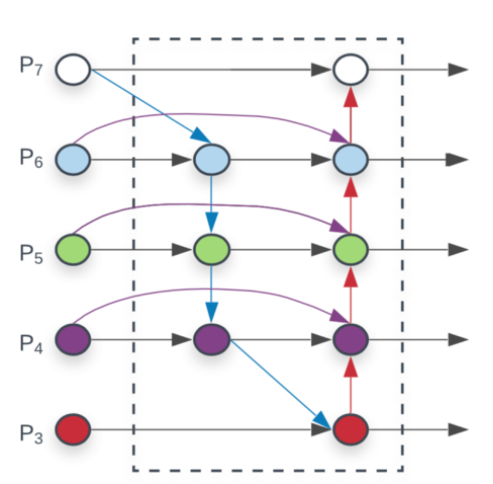

The final BiFPN integrates both bidirectional cross-scale connections the fast normalisation method. An example of this is shown below, which is the 6th layer in the BiFPN:

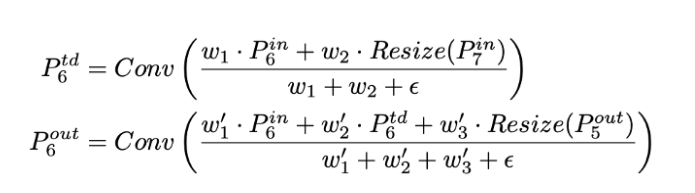

The top equation is the intermediate for the top-down pathway and the bottom is the equation for the bottom-up pathway.

At the end, the fused features are fed into a class and box network to predict the object class and bounding box.

In [3]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-pe2tqokn
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-pe2tqokn
     |████████████████████████████████| 952kB 2.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65438 sha256=ea6bceda51942687d5c17bca049517e558b7faaf6dd074cf2858aee005717842
  Stored in directory: /tmp/pip-ephem-wheel-cache-unqkc364/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
!pip install ensemble-boxes

In [5]:
!pip install timm

     |████████████████████████████████| 215kB 2.7MB/s 


In [6]:
!pip install pycocotools

In [7]:
!pip install -U git+https://github.com/rwightman/efficientdet-pytorch

  Cloning https://github.com/rwightman/efficientdet-pytorch to /tmp/pip-req-build-5lt3hkxi
  Running command git clone -q https://github.com/rwightman/efficientdet-pytorch /tmp/pip-req-build-5lt3hkxi
  Created wheel for effdet: filename=effdet-0.1.4-cp36-none-any.whl size=51076 sha256=0a5ed782533daa1a7f81c9b82a9a987d62d30cb05beed867c5d41a0d5131e700
  Stored in directory: /tmp/pip-ephem-wheel-cache-fbnlnh91/wheels/b8/5f/71/526b406ac099c9cc234802355382bb3f451278c23bbcec54a4
Successfully built effdet


In [8]:
!pip install omegaconf

In [9]:
!nvidia-smi

Thu Aug  6 10:44:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain , DetBenchPredict
from effdet.efficientdet import HeadNet

In [11]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim
import os
import glob
import gc
import pycocotools
from tqdm.auto import tqdm
from tqdm import tqdm_notebook
import random
import time
from datetime import datetime
from ensemble_boxes import *
from itertools import product
%matplotlib inline
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from albumentations import (Blur, MotionBlur, MedianBlur, GaussianBlur,
                            VerticalFlip, HorizontalFlip, IAASharpen,
                            OneOf, Compose , BboxParams, Resize, HueSaturationValue
                            ,RandomBrightnessContrast, ToGray , Cutout ,  RandomSizedCrop)

# **Path directories**

In [14]:
DIR_PATH = '/content/drive/My Drive/Global Wheat Detection/'
dir = glob.glob(os.path.join('/content/drive/My Drive/Global Wheat Detection/*'))
dir.sort(reverse=True)
train_paths = glob.glob(os.path.join(dir[1] , '*'))
test_paths = glob.glob(os.path.join(dir[2] , '*'))

# **Read Dataframe**

In [15]:
df = pd.read_csv(dir[0])
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df

image_id  width  height     source      x      y      w      h
0       b6ab77fd7   1024    1024    usask_1  834.0  222.0   56.0   36.0
1       b6ab77fd7   1024    1024    usask_1  226.0  548.0  130.0   58.0
2       b6ab77fd7   1024    1024    usask_1  377.0  504.0   74.0  160.0
3       b6ab77fd7   1024    1024    usask_1  834.0   95.0  109.0  107.0
4       b6ab77fd7   1024    1024    usask_1   26.0  144.0  124.0  117.0
...           ...    ...     ...        ...    ...    ...    ...    ...
147788  5e0747034   1024    1024  arvalis_2   64.0  619.0   84.0   95.0
147789  5e0747034   1024    1024  arvalis_2  292.0  549.0  107.0   82.0
147790  5e0747034   1024    1024  arvalis_2  134.0  228.0  141.0   71.0
147791  5e0747034   1024    1024  arvalis_2  430.0   13.0  184.0   79.0
147792  5e0747034   1024    1024  arvalis_2  875.0  740.0   94.0   61.0

[147793 rows x 8 columns]

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

df_folds

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


bbox_count     source stratify_group  fold
image_id                                             
00333207f          55  arvalis_1    arvalis_1_3     1
005b0d8bb          20    usask_1      usask_1_1     3
006a994f7          25    inrae_1      inrae_1_1     1
00764ad5d          41    inrae_1      inrae_1_2     0
00b5fefed          25  arvalis_3    arvalis_3_1     3
...               ...        ...            ...   ...
ffb445410          57     rres_1       rres_1_3     1
ffbf75e5b          52  arvalis_1    arvalis_1_3     1
ffbfe7cc0          34  arvalis_1    arvalis_1_2     3
ffc870198          41    usask_1      usask_1_2     4
ffdf83e42          39  arvalis_1    arvalis_1_2     4

[3373 rows x 4 columns]

In [17]:
df_folds.groupby('fold')['bbox_count'].mean()

fold
0    43.509630
1    44.179259
2    43.734815
3    43.767062
4    43.891691
Name: bbox_count, dtype: float64

# **Help functions**

In [38]:
def show_image(image, boxes, title):
  fig, ax = plt.subplots(1, 1, figsize=(25, 8))
  boxes = boxes.astype(np.int32)
  for box in boxes:
      cv2.rectangle(image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 3)
  ax.set_title(title) 
  ax.set_axis_off()
  ax.imshow(image);


def load_image_and_boxes(image_path):
  image_id = image_path.split('/')[-1].split('.')[0]
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.0
  records = df[df['image_id'] == image_id]
  boxes = records[['x', 'y', 'w', 'h']].values
  boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
  boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
  return image, boxes


def images_after_augmentation(original_image, boxes, augmentation):
    aug_image = original_image.copy()
    boxes = boxes.astype(np.int32)
    if isinstance(augmentation , VerticalFlip) or isinstance(augmentation , HorizontalFlip):
      for box in boxes:
          cv2.rectangle(aug_image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 2)
      sample = {'image': aug_image, 'label': 'label'}
      compose = Compose([augmentation], p=1)
      aug_image = compose(**sample)['image']
    else:
      sample = {'image': aug_image, 'label': 'label'}
      compose = Compose([augmentation], p=1)
      aug_image = compose(**sample)['image']
      for box in boxes:
          cv2.rectangle(aug_image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 2)
    plt.figure(figsize=[12, 12])
    for i in range(len([original_image, aug_image])):
            image = [original_image, aug_image][i]
            plt.subplot(1, 2, i+1)
            plt.title(['Original Image', 'After Augmentaion'][i])
            plt.axis("off")
            plt.imshow(image)
    plt.show()


# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


BOX_COLOR = (255, 255, 0)


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=3):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax =  int(xmin), int(ymin), int(xmax), int(ymax)
    # cv2.rectangle(img,(ymax , xmax), (ymin,xmin), color=BOX_COLOR, thickness=thickness)
    cv2.rectangle(img,(xmin, ymin),(xmax , ymax), color=BOX_COLOR, thickness=thickness)
    return img

def visualizeTarget(image, target , visualize_data_loader = True):
  boxes = target['boxes']
  if visualize_data_loader:
    if not type(boxes).__module__ == np.__name__:
      boxes = boxes.numpy()
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
  img = image.copy()
  for idx, bbox in enumerate(boxes):
      img = visualize_bbox(img, bbox)
  return img

# **Examples**

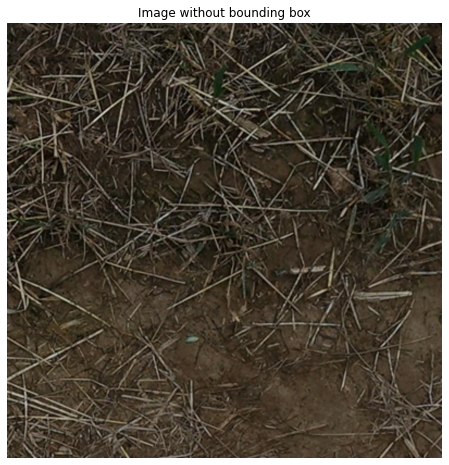

In [19]:
image_id = '8425a537b.jpg'
image_path = glob.glob(os.path.join(dir[1] , image_id))
image , boxes  = load_image_and_boxes(image_path[0])
show_image(image, boxes, "Image without bounding box")
# 8425a537b

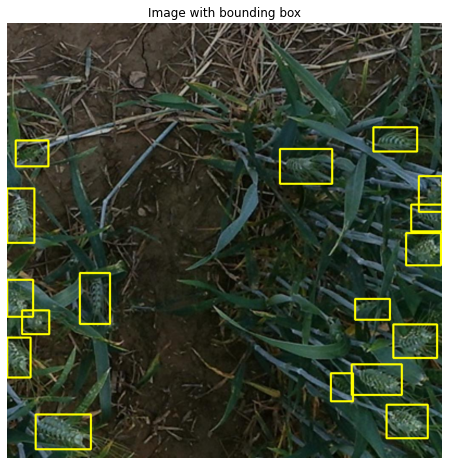

In [20]:
image_id = 'b3c96d5ad.jpg'
image_path = glob.glob(os.path.join(dir[1] , image_id))
image , boxes  = load_image_and_boxes(image_path[0])
show_image(image, boxes, "Image with bounding box")

# **Examples of some augmentations that we will use for our train** 




## **Blur**

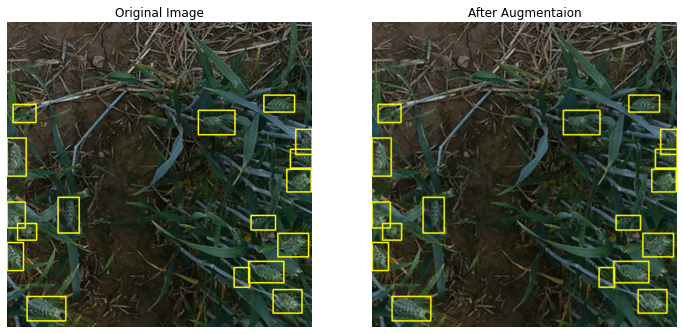

In [21]:
images_after_augmentation(image, boxes, Blur(blur_limit=7 ,p=1))

## **Vertical Flip**

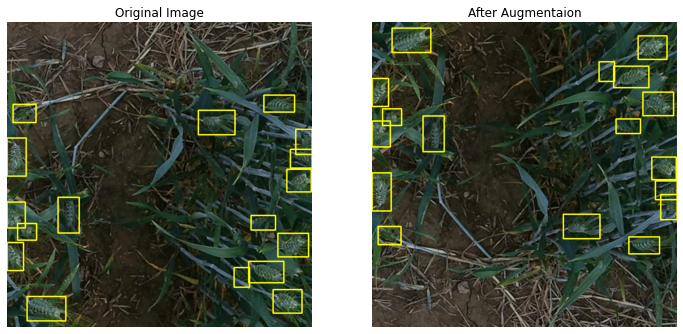

In [22]:
images_after_augmentation(image, boxes, VerticalFlip(p=1))

## **Horizontal Flip**

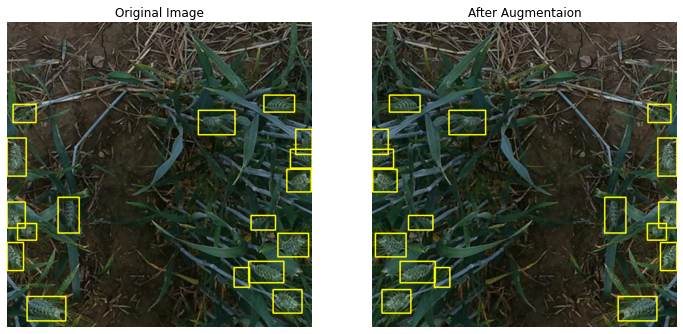

In [23]:
images_after_augmentation(image, boxes, HorizontalFlip(p=1))

# **Wheat dataset**

In [33]:
class WheatDataset(Dataset):
    def __init__(self , dataframe , image_ids,  transforms = None):
        super().__init__()
        self.image_ids = image_ids
        self.dataframe = dataframe
        self.transforms = transforms


    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
    
        image, boxes = self.load_image_and_boxes(index)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
 
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
    
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                        'image': image,
                        'bboxes': target['boxes'],
                        'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['labels'] = torch.stack(sample['labels'])
                    break
        return image, target, image_id
              
      
    def __len__(self) -> int:
        return self.image_ids.shape[0]


    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{dir[1]}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.dataframe[self.dataframe['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        area = (boxes[:, 2] * boxes[:, 3])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes


# **Augmentations**

In [34]:
transforms_train = Compose([IAASharpen(p = 0.5), RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),ToGray(p=0.01),
                            OneOf([HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                                    RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=0.9)],p=0.8),
                            OneOf([Blur(blur_limit=3), MotionBlur(blur_limit=3), MedianBlur(blur_limit=3)]),
                            OneOf([VerticalFlip(), HorizontalFlip()]),
                            Cutout(num_holes=10, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                            Resize(height=512, width=512, p = 1.0)
                            ,ToTensorV2(p=1.0),
                            ],p = 1.0,bbox_params=BboxParams(format='pascal_voc', min_area=0, 
                                               min_visibility=0, label_fields=['labels']))


transforms_valid = Compose([Resize(height=512, width=512, p=1.0),
                            ToTensorV2(p=1.0),], p=1.0,
                            bbox_params=BboxParams(
                                format='pascal_voc',
                                min_area=0,
                                min_visibility=0,
                                label_fields=['labels']))

# **Data Loader**

In [35]:
def collate_fn(batch):
  return tuple(zip(*batch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


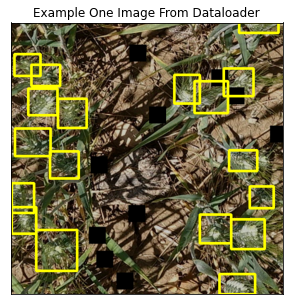

In [39]:
bs = 2
fold_number = 0

train_set = WheatDataset(dataframe=df, image_ids=df_folds[df_folds['fold'] != fold_number].index.values , transforms=transforms_train)
valid_set = WheatDataset(dataframe=df, image_ids=df_folds[df_folds['fold'] == fold_number].index.values , transforms=transforms_valid)

train_loader = DataLoader(train_set,batch_size = bs,sampler=RandomSampler(train_set),pin_memory=False,
        drop_last=True,collate_fn=collate_fn , num_workers=2)
valid_loader = DataLoader(valid_set,batch_size = bs ,sampler=SequentialSampler(valid_set),pin_memory=False,
        drop_last=True,collate_fn=collate_fn , num_workers=2)

images , targets , path_images = next(iter(train_loader))
img = visualizeTarget(images[0],targets[0])
visualize(Example_one_image_from_dataloader = img)

# **Train/Validation**

In [40]:
class Calculator(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [42]:
class Training:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.best_calc_loss = 10**5

        self.model = model
        self.device = device


        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)


    def train_loop(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                print(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            calc_loss = self.train_one_epoch(train_loader)
            self.config.epoch.append(e)
            self.config.train_loss.append(calc_loss.avg)
            print(f'Train. Epoch: {self.epoch}, Loss: {calc_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save_model(f'{self.base_dir}/last-epoch.bin')

            t = time.time()
            calc_loss = self.valid_one_epoch(validation_loader)
            self.config.valid_loss.append(calc_loss.avg)
            print(f'Val. Epoch: {self.epoch}, Loss: {calc_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if calc_loss.avg < self.best_calc_loss:
                self.best_calc_loss = calc_loss.avg
                self.model.eval()
                self.save_model(f'{self.base_dir}/best-model-{str(self.epoch).zfill(2)}epoch.bin')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=calc_loss.avg)

            self.epoch += 1


    def train_one_epoch(self, train_loader):
        self.model.train()
        calc_loss = Calculator()
        t = time.time()
        target_res = {}
        for images, targets, image_ids in tqdm_notebook(train_loader):
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels  

            self.optimizer.zero_grad()

            outputs = self.model(images, target_res)
            loss = outputs['loss']
            calc_loss.update(loss.detach().item(), batch_size)
        
            loss.backward()
            self.optimizer.step()

            if self.config.step_scheduler:  
                self.scheduler.step()
      
        return calc_loss


    
    def valid_one_epoch(self, val_loader):
        self.model.eval()
        calc_loss = Calculator()
        t = time.time()
        
        with torch.no_grad():
            for images, targets, image_ids in tqdm_notebook(val_loader):
                images = torch.stack(images)
                images = images.to(self.device).float()
                batch_size = images.shape[0]
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)
        
                outputs = self.model(images, target_res)
                loss = outputs['loss']
                calc_loss.update(loss.detach().item(), batch_size)
        return calc_loss


    def save_model(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_calc_loss': self.best_calc_loss,
            'epoch': self.epoch,
        }, path)


    def load_model(self, path):
        model = torch.load(path)
        self.model.load_state_dict(model['model_state_dict'])
        self.optimizer.load_state_dict(model['optimizer_state_dict'])
        self.scheduler.load_state_dict(model['scheduler_state_dict'])
        self.best_calc_loss = model['best_calc_loss']
        self.epoch = model['epoch'] + 1

    def display_graph(self):
      plt.plot(self.config.epoch, self.config.train_loss)
      plt.plot(self.config.epoch , self.config.valid_loss)
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend(["Train", "Validation"])

# **EfficientDet_D5 Model**
`num_classes = 1` - only one class called wheat





In [43]:
def get_model(num_classes = 1):
  config = get_efficientdet_config('tf_efficientdet_d5')
  model = EfficientDet(config, pretrained_backbone=False)
  checkpoint = torch.load('/content/drive/My Drive/Global Wheat Detection/efficientdet_d7/efficientdet_d5-ef44aea8.pth')
  model.load_state_dict(checkpoint)
  config.num_classes = num_classes
  config.image_size = 512
  model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
  return DetBenchTrain(model, config)

In [ ]:
class GlobalParametersTrain:
    lr = 0.0002 
    n_epochs = 40 

    train_loss = []
    valid_loss = []
    epoch = []

    folder = '/content/drive/My Drive/Global Wheat Detection/efficientdet_d5'

    verbose = True
    verbose_step = 10

    step_scheduler = False 
    validation_scheduler = True 
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(mode='min',factor=0.5,patience=1,verbose=False, threshold=0.0001,threshold_mode='abs',cooldown=0, min_lr=1e-8,eps=1e-08)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training = Training(model=get_model().to(device), device=device, config=GlobalParametersTrain)
training.train_loop(train_loader, valid_loader)
training.display_graph()


2020-08-03T21:57:50.995468
LR: 0.0002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Train. Epoch: 0, Loss: 1.78593, time: 396.44317


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Val. Epoch: 0, Loss: 0.47765, time: 30.58353

2020-08-03T22:05:01.542120
LR: 0.0002



Train. Epoch: 1, Loss: 0.47111, time: 396.49054



Val. Epoch: 1, Loss: 0.40950, time: 30.71491

2020-08-03T22:12:12.143690
LR: 0.0002



Train. Epoch: 2, Loss: 0.44375, time: 397.33033



Val. Epoch: 2, Loss: 0.39843, time: 31.18130

2020-08-03T22:19:24.013215
LR: 0.0002



Train. Epoch: 3, Loss: 0.43058, time: 399.39310



Val. Epoch: 3, Loss: 0.39441, time: 31.07431

2020-08-03T22:26:38.305209
LR: 0.0002



Train. Epoch: 4, Loss: 0.42036, time: 399.35235



Val. Epoch: 4, Loss: 0.40392, time: 31.17143

2020-08-03T22:33:50.666957
LR: 0.0002



Train. Epoch: 5, Loss: 0.41127, time: 398.69742



Val. Epoch: 5, Loss: 0.38468, time: 30.85947

2020-08-03T22:41:03.804894
LR: 0.0002



Train. Epoch: 6, Loss: 0.40762, time: 399.36810



Val. Epoch: 6, Loss: 0.37821, time: 31.19844

2020-08-03T22:48:17.842481
LR: 0.0002



Train. Epoch: 7, Loss: 0.40215, time: 400.36459



Val. Epoch: 7, Loss: 0.37685, time: 30.99278

2020-08-03T22:55:32.756317
LR: 0.0002



Train. Epoch: 8, Loss: 0.39876, time: 399.09219



Val. Epoch: 8, Loss: 0.37837, time: 31.17041

2020-08-03T23:02:44.690642
LR: 0.0002



Train. Epoch: 9, Loss: 0.39962, time: 398.17718



Val. Epoch: 9, Loss: 0.38344, time: 31.31737

2020-08-03T23:09:56.004104
LR: 0.0001



Train. Epoch: 10, Loss: 0.38151, time: 398.02539



Val. Epoch: 10, Loss: 0.36806, time: 30.80015

2020-08-03T23:17:08.436715
LR: 0.0001



Train. Epoch: 11, Loss: 0.37771, time: 399.63454



Val. Epoch: 11, Loss: 0.36584, time: 30.93758

2020-08-03T23:24:22.589810
LR: 0.0001



Train. Epoch: 12, Loss: 0.37295, time: 398.92654



Val. Epoch: 12, Loss: 0.36679, time: 31.12899

2020-08-03T23:31:34.301248
LR: 0.0001



Train. Epoch: 13, Loss: 0.37143, time: 397.78426



Val. Epoch: 13, Loss: 0.37556, time: 30.94148

2020-08-03T23:38:44.869155
LR: 5e-05



Train. Epoch: 14, Loss: 0.36322, time: 397.08330



Val. Epoch: 14, Loss: 0.36222, time: 31.01639

2020-08-03T23:45:56.520001
LR: 5e-05



Train. Epoch: 15, Loss: 0.35950, time: 396.83999



Val. Epoch: 15, Loss: 0.36319, time: 31.34356

2020-08-03T23:53:06.362404
LR: 5e-05



Train. Epoch: 16, Loss: 0.35792, time: 396.54492



Val. Epoch: 16, Loss: 0.36334, time: 30.61704

2020-08-04T00:00:15.297405
LR: 2.5e-05



Train. Epoch: 17, Loss: 0.35055, time: 396.49456



Val. Epoch: 17, Loss: 0.36157, time: 30.55312

2020-08-04T00:07:25.685934
LR: 2.5e-05



Train. Epoch: 18, Loss: 0.34915, time: 396.44228



Val. Epoch: 18, Loss: 0.36433, time: 30.51844

2020-08-04T00:14:34.379759
LR: 2.5e-05



Train. Epoch: 19, Loss: 0.34794, time: 396.86264



Val. Epoch: 19, Loss: 0.36374, time: 30.82170

2020-08-04T00:21:45.139547
LR: 0.0002



Train. Epoch: 0, Loss: 1.57482, time: 397.41596



Val. Epoch: 0, Loss: 0.47546, time: 30.61004

2020-08-04T00:28:56.556624
LR: 0.0002



Train. Epoch: 1, Loss: 0.46579, time: 397.65332



Val. Epoch: 1, Loss: 0.41442, time: 30.61960

2020-08-04T00:36:08.610104
LR: 0.0002



Train. Epoch: 2, Loss: 0.43949, time: 396.29687



Val. Epoch: 2, Loss: 0.40217, time: 31.24830

2020-08-04T00:43:19.507555
LR: 0.0002



Train. Epoch: 3, Loss: 0.42550, time: 396.70332



Val. Epoch: 3, Loss: 0.40054, time: 30.41772

2020-08-04T00:50:31.219208
LR: 0.0002



Train. Epoch: 4, Loss: 0.41897, time: 397.00455



Val. Epoch: 4, Loss: 0.39184, time: 30.66320

2020-08-04T00:57:42.404169
LR: 0.0002



Train. Epoch: 5, Loss: 0.41176, time: 396.82205



Val. Epoch: 5, Loss: 0.38604, time: 30.62774

2020-08-04T01:04:53.323415
LR: 0.0002



Train. Epoch: 6, Loss: 0.40861, time: 396.88384



Val. Epoch: 6, Loss: 0.37811, time: 30.66352

2020-08-04T01:12:04.439827
LR: 0.0002



Train. Epoch: 7, Loss: 0.40261, time: 397.09509



Val. Epoch: 7, Loss: 0.38088, time: 30.69949

2020-08-04T01:19:14.055864
LR: 0.0002



Train. Epoch: 8, Loss: 0.39866, time: 397.40507



Val. Epoch: 8, Loss: 0.37738, time: 30.58703

2020-08-04T01:26:25.565206
LR: 0.0002



Train. Epoch: 9, Loss: 0.39623, time: 397.45059



Val. Epoch: 9, Loss: 0.37444, time: 30.61791

2020-08-04T01:33:37.265346
LR: 0.0002



Train. Epoch: 10, Loss: 0.39231, time: 397.61933



Val. Epoch: 10, Loss: 0.37518, time: 30.69277

2020-08-04T01:40:47.410744
LR: 0.0002



Train. Epoch: 11, Loss: 0.39045, time: 396.76686



Val. Epoch: 11, Loss: 0.38043, time: 30.46093

2020-08-04T01:47:56.474534
LR: 0.0001



Train. Epoch: 12, Loss: 0.37373, time: 397.76337



Val. Epoch: 12, Loss: 0.36860, time: 30.85300

2020-08-04T01:55:08.564609
LR: 0.0001



Train. Epoch: 13, Loss: 0.36951, time: 397.47564



Val. Epoch: 13, Loss: 0.36651, time: 30.59513

2020-08-04T02:02:20.098481
LR: 0.0001



Train. Epoch: 14, Loss: 0.36780, time: 397.28754



Val. Epoch: 14, Loss: 0.36774, time: 31.29377

2020-08-04T02:09:30.567675
LR: 0.0001



Train. Epoch: 15, Loss: 0.36531, time: 396.43122



Val. Epoch: 15, Loss: 0.36844, time: 30.42529

2020-08-04T02:16:39.150383
LR: 5e-05



Train. Epoch: 16, Loss: 0.35735, time: 396.87985



Val. Epoch: 16, Loss: 0.36329, time: 30.47496

2020-08-04T02:23:49.953570
LR: 5e-05



Train. Epoch: 17, Loss: 0.35333, time: 397.86548



Val. Epoch: 17, Loss: 0.36666, time: 30.49909

2020-08-04T02:31:00.052917
LR: 5e-05



Train. Epoch: 18, Loss: 0.35175, time: 397.26674



Val. Epoch: 18, Loss: 0.36375, time: 30.45384

2020-08-04T02:38:09.546845
LR: 2.5e-05



Train. Epoch: 19, Loss: 0.34561, time: 397.05351



Val. Epoch: 19, Loss: 0.36474, time: 30.63143


### **Load best efficientdet d5 model are trained**

In [44]:
def load_model(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    model = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    model = DetBenchPredict(model, config)
    model.eval();
    return model.cuda()

# model = load_model('/content/drive/My Drive/Global Wheat Detection/efficientdet_d5/efficient-best-44epoch.bin')
model = load_model('/content/drive/My Drive/Global Wheat Detection/efficientdet_d5/efficient-best-017epoch.bin')


In [ ]:
training = Training(model=get_model().to(device), device=device, config=GlobalParametersTrain)
training.load_model('/content/drive/My Drive/Global Wheat Detection/efficientdet_d5/efficient-best-017epoch.bin')
training.train_loop(train_loader, valid_loader)


2020-07-31T16:43:45.735372
LR: 2.5e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Train. Epoch: 18, Loss: 0.34837, time: 432.66865


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Val. Epoch: 18, Loss: 0.36387, time: 31.61659

2020-07-31T16:51:32.016073
LR: 2.5e-05



Train. Epoch: 19, Loss: 0.34562, time: 434.50257



Val. Epoch: 19, Loss: 0.36269, time: 31.88076

2020-07-31T16:59:20.127462
LR: 1.25e-05



Train. Epoch: 20, Loss: 0.34371, time: 431.85323



Val. Epoch: 20, Loss: 0.36419, time: 31.38040

2020-07-31T17:07:05.250093
LR: 1.25e-05



Train. Epoch: 21, Loss: 0.34251, time: 431.13931



Val. Epoch: 21, Loss: 0.36238, time: 31.64857

2020-07-31T17:14:49.750180
LR: 6.25e-06



Train. Epoch: 22, Loss: 0.34107, time: 431.18316



Val. Epoch: 22, Loss: 0.36348, time: 31.47750

2020-07-31T17:22:34.131060
LR: 6.25e-06



Train. Epoch: 23, Loss: 0.34059, time: 430.93922



Val. Epoch: 23, Loss: 0.36527, time: 31.32023

2020-07-31T17:30:18.255344
LR: 3.125e-06



Train. Epoch: 24, Loss: 0.33947, time: 432.03553



Val. Epoch: 24, Loss: 0.36299, time: 31.65530

2020-07-31T17:38:03.575184
LR: 3.125e-06



Train. Epoch: 25, Loss: 0.33931, time: 430.90926



Val. Epoch: 25, Loss: 0.36421, time: 31.42856

2020-07-31T17:45:47.586153
LR: 1.5625e-06



Train. Epoch: 26, Loss: 0.33802, time: 430.88678



Val. Epoch: 26, Loss: 0.36442, time: 31.59162

2020-07-31T17:53:31.752537
LR: 1.5625e-06



Train. Epoch: 27, Loss: 0.33870, time: 430.78739



Val. Epoch: 27, Loss: 0.36436, time: 31.35108


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_predictions(images ,  score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        outputs = model(images , torch.tensor([1.0] * images.shape[0], dtype=torch.float).to(device) , torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(device))
        for i in range(images.shape[0]):
            boxes = outputs[i].detach().cpu().numpy()[:,:4]    
            scores = outputs[i].detach().cpu().numpy()[:,4]
            labels = outputs[i].detach().cpu().numpy()[:,5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return [predictions]

# **Weighted Boxes Fusion**



In [46]:
def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    # labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    labels = [prediction[image_index]['labels'].tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [47]:
for j, (images, targets , image_ids) in enumerate(valid_loader):
    break
predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


### **Example from validation set of ground truth vs prediction**  


---





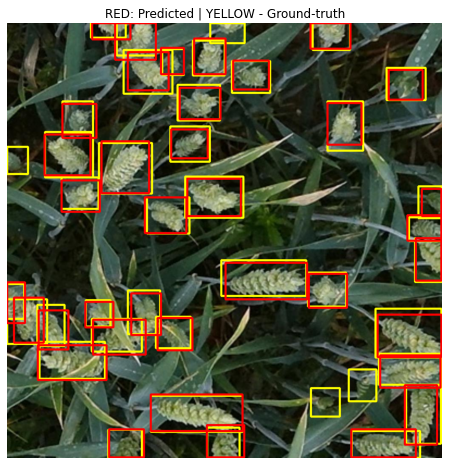

In [50]:
def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{dir[1]}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    preds = (preds*2).astype(np.int32).clip(min=0, max=1023)
    gt_boxes = (gt_boxes*2).astype(np.int32).clip(min=0, max=1023)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (255, 255, 0), 3
        )
        
    for pred_box in preds:
        cv2.rectangle(sample,(pred_box[0], pred_box[1]),(pred_box[2], pred_box[3]),
            (255, 0, 0), 3)
    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | YELLOW - Ground-truth")
show_result(image_ids[0], boxes, targets[0]['boxes'].numpy())

# **TTA Classes**

In [58]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

# **Combinations of TTA**

In [59]:
from itertools import product
tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], [TTAVerticalFlip(), None],[TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [60]:
def make_tta_predictions(images, score_threshold=0.5):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            outputs = model(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda() ,  torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(device))

            for i in range(images.shape[0]):
                boxes = outputs[i].detach().cpu().numpy()[:,:4]    
                scores = outputs[i].detach().cpu().numpy()[:,4]
                labels = outputs[i].detach().cpu().numpy()[:,5]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                    'labels': labels[indexes],
                })
            predictions.append(result)
    return predictions

/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


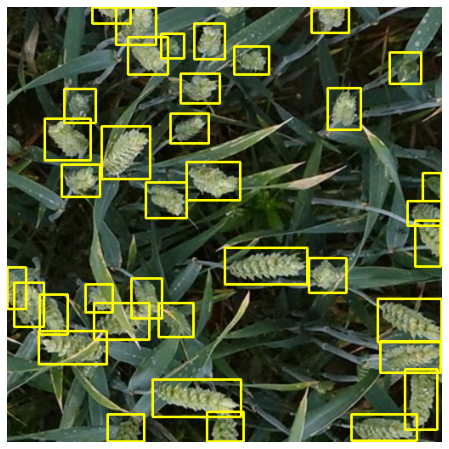

In [61]:
for j, (images, targets , image_ids) in enumerate(valid_loader):
    break


predictions = make_tta_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample);

# **Inference**

In [62]:
test_transforms =  Compose([
            Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [68]:
class TestDataset(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{dir[2]}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [69]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [70]:
test_set = TestDataset(image_ids=np.array([path.split('/')[-1][:-4] for path in test_paths]),transforms=test_transforms)
test_loader = DataLoader(test_set,batch_size=4,shuffle=False,num_workers=2,drop_last=False,collate_fn=collate_fn)

In [71]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [72]:
submission = []

for images, image_ids in test_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        img = visualizeTarget(image, {'boxes' : boxes} , visualize_data_loader = True)
        visualize(test_image = img)
        
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        submission.append(result)

Output hidden; open in https://colab.research.google.com to view.

# **Submission**

In [73]:
SUBMISSION_PATH = '/content/drive/My Drive/Global Wheat Detection/efficientdet_d5/submission'
submission_id = 'submission'
submission_path = os.path.join(SUBMISSION_PATH, '{}.csv'.format(submission_id))
sample_submission = pd.DataFrame(submission, columns=["image_id","PredictionString"])
sample_submission.to_csv(submission_path, index=False)
submission_df = pd.read_csv(submission_path)
submission_df

image_id                                   PredictionString
0  51b3e36ab  0.8934 497 356 312 133 0.8823 869 288 152 142 ...
1  348a992bb  0.8733 733 222 141 88 0.8500 139 39 116 88 0.8...
2  2fd875eaa  0.9054 0 910 104 83 0.8808 533 867 109 120 0.8...
3  51f1be19e  0.8361 608 84 156 172 0.8322 838 265 138 205 0...
4  aac893a91  0.8794 565 538 112 179 0.8533 696 394 111 171 ...
5  cc3532ff6  0.9489 772 831 161 158 0.8827 911 124 110 94 0...
6  cb8d261a3  0.8513 903 176 92 119 0.8470 603 248 75 125 0....
7  796707dd7  0.8874 710 825 106 98 0.8775 896 334 110 89 0....
8  f5a1f0358  0.8977 543 273 108 111 0.8818 690 206 109 89 0...
9  53f253011  0.8579 621 100 118 148 0.8541 233 839 116 95 0...

# **Summary**

In this notebook we implemented second model(EfficentDet) in this competition.

We researched various networks that solve the problem of object detection and read that this network is currently considered the state-of-the-art and even efficient in the amount of calculations.

Also, we have seen many notebooks use this model and even achieve high results, so we decided go with that.


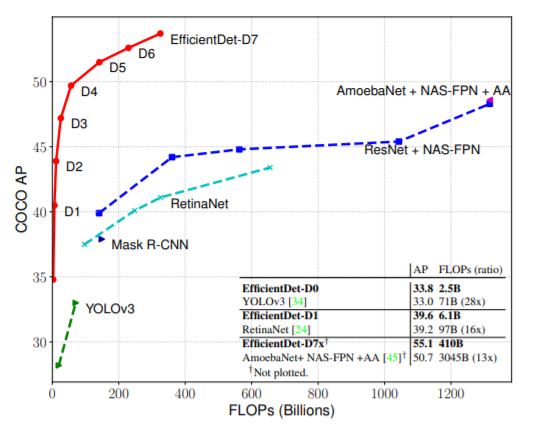

**Notebook steps:**

1.   Read train.csv file
2.   Augmentations

1.   Define Dataloader
2.   Train / Validation

1.   Load model
2.   Weighted Boxes Fusion 

1.   Test Time Augmentation

1.   Calculate score and prediction (Test)
2.   Create submission csv file


In this notebook as opposed to FasterRCNN model we had to read the data from the dataframe in order to get images only with bounding boxes.

We divided the data from the dataframe using StraightKFold.

We started with augmentations which we used in a first notebook and the results improved to score of 0.7237 in Public LB.

In addition, we used the combination of WBF with TTA in order to eliminate "good" boxes when objects are highly overlapping and to predict bounding boxes using TTA single model.

Finally, the model receives a set of images and output for each them.

Outputs:

Boxes - when the boxes indicate the coordinates in the format x, y, w, h.

Score - probability value between 0 and 1.

Label - to which category the box belongs.

In this notebook of **EfficientDet** model we got the best score of **0.7237**

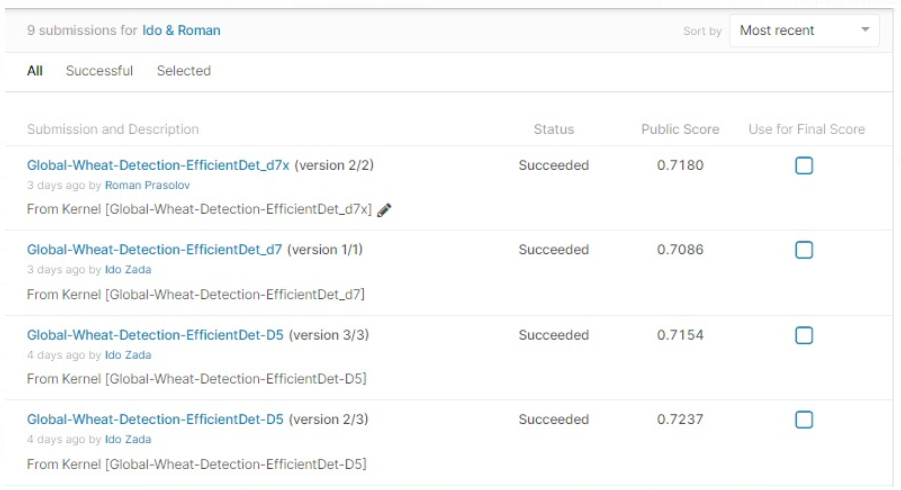